In [2]:
# ====================================================
# Library
# ====================================================

import os
import copy
import time
from random import randrange, randint

import cv2
from PIL import Image

from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from skimage import io
from sklearn import metrics
from sklearn.metrics import confusion_matrix
# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
#%matplotlib qt
%matplotlib inline
#%matplotlib notebook

import timm

import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torchvision.models as models
from torch.optim import SGD, Adam
from torch.optim import lr_scheduler

import albumentations as A
from albumentations.pytorch import ToTensorV2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'working with {device}')

working with cuda


## Import train csv

In [3]:
PATH = '/home/nico/Desktop/MarieCurie/Flowcam/train/'

train = pd.read_csv(PATH + 'train.csv')

# Let's drop some useless features
todrop = ['Particle ID',
          'Calibration Factor',
          'Calibration Image',
          'Camera',
          'Capture X',
          'Capture Y',
          'Date',
          'Elapsed Time',
          'Filter Score',
          'Image File',
          'Image Height',
          'Image Width',
          'Image X',
          'Image Y',
          'Source Image',
          'Time',
          'Timestamp',
          'imgpaths'
         ]
train.drop(columns=todrop, inplace=True)

display(train.sample(10))

print(train.columns)

,Area (ABD),Area (Filled),Aspect Ratio,Biovolume (Cylinder),Biovolume (P. Spheroid),Biovolume (Sphere),Circle Fit,Circularity,Circularity (Hu),Compactness,...,Transparency,Volume (ABD),Volume (ESD),Width,camp,corylus,dust,grim,qrob,qsub
126653,1281.92,1285.67,0.90,23930.64,33210.41,34526.77,0.59,0.62,0.99,1.63,...,0.03,34526.770000,37600.420000,38.94,0,0,0,0,0,1
102683,3026.72,3026.72,0.69,56759.55,122382.70,125262.82,0.28,0.39,0.84,2.59,...,0.17,125262.800000,220385.200000,62.34,0,0,0,1,0,0
9139,19.60,20.15,0.76,85.35,62.58,65.27,0.70,0.63,0.91,1.58,...,0.13,65.271140,99.452310,4.81,1,0,0,0,0,0
33010,25.50,25.50,0.47,174.09,59.29,96.88,0.48,0.78,0.75,1.28,...,0.15,96.880790,155.039800,3.44,1,0,0,0,0,0
20928,23.70,23.70,0.77,134.74,73.27,86.82,0.82,0.91,0.96,1.10,...,0.05,86.816100,100.260300,4.87,1,0,0,0,0,0
67413,451.41,479.44,0.90,9193.73,7498.68,7214.62,0.86,0.81,0.99,1.24,...,0.05,7214.621000,8451.851000,23.73,0,1,0,0,0,0
98641,0.06,0.00,1.00,0.00,0.00,0.01,0.00,0.00,0.00,1.27,...,0.00,0.010913,0.010913,0.28,0,0,1,0,0,0
116479,685.72,685.72,0.78,12903.57,11902.01,13507.67,0.70,0.75,0.97,1.33,...,0.04,13507.670000,15040.050000,26.51,0,0,0,0,1,0
5717,43.80,45.55,0.47,170.47,161.44,218.04,0.39,0.44,0.71,2.28,...,0.21,218.036000,436.921600,5.09,1,0,0,0,0,0
76961,0.28,0.28,0.47,0.65,0.08,0.11,0.80,1.00,0.73,1.00,...,0.18,0.113856,0.208228,0.41,0,0,1,0,0,0


Index(['Area (ABD)', 'Area (Filled)', 'Aspect Ratio', 'Biovolume (Cylinder)',
       'Biovolume (P. Spheroid)', 'Biovolume (Sphere)', 'Circle Fit',
       'Circularity', 'Circularity (Hu)', 'Compactness', 'Convex Perimeter',
       'Convexity', 'Diameter (ABD)', 'Diameter (ESD)', 'Edge Gradient',
       'Elongation', 'Feret Angle Max', 'Feret Angle Min', 'Fiber Curl',
       'Fiber Straightness', 'Geodesic Aspect Ratio', 'Geodesic Length',
       'Geodesic Thickness', 'Intensity', 'Length', 'Particles Per Chain',
       'Perimeter', 'Roughness', 'Sigma Intensity', 'Sphere Complement',
       'Sphere Count', 'Sphere Unknown', 'Sphere Volume', 'Sum Intensity',
       'Symmetry', 'Transparency', 'Volume (ABD)', 'Volume (ESD)', 'Width',
       'camp', 'corylus', 'dust', 'grim', 'qrob', 'qsub'],
      dtype='object')


In [4]:
Ntrain, Nval = 6000, 1000

camp = train.loc[train['camp'] == 1]
corylus = train.loc[train['corylus'] == 1]
dust = train.loc[train['dust'] == 1]
grim = train.loc[train['grim'] == 1]
qrob = train.loc[train['qrob'] == 1]
qsub = train.loc[train['qsub'] == 1]

minN = min(len(camp), len(corylus), len(dust), len(grim), len(qrob), len(qsub)) #7824

camp_train = camp.sample(minN).sample(Ntrain)
camp_val = camp.drop(camp_train.index).sample(Nval)

corylus_train = corylus.sample(minN).sample(Ntrain)
corylus_val = corylus.drop(corylus_train.index).sample(Nval)

dust_train = dust.sample(minN).sample(Ntrain)
dust_val = dust.drop(dust_train.index).sample(Nval)

grim_train = grim.sample(minN).sample(Ntrain)
grim_val = grim.drop(grim_train.index).sample(Nval)

qrob_train = qrob.sample(minN).sample(Ntrain)
qrob_val = qrob.drop(qrob_train.index).sample(Nval)

qsub_train = qsub.sample(minN).sample(Ntrain)
qsub_val = qsub.drop(qsub_train.index).sample(Nval)

train = pd.concat([camp_train, corylus_train, dust_train, grim_train, qrob_train, qsub_train], ignore_index = True)
val = pd.concat([camp_val, corylus_val, dust_val, grim_val, qrob_val, qsub_val], ignore_index = True)

print(len(train))
print(len(val))

display(train.sample(3))
print(train.info())
print(val.info())

36000
6000


,Area (ABD),Area (Filled),Aspect Ratio,Biovolume (Cylinder),Biovolume (P. Spheroid),Biovolume (Sphere),Circle Fit,Circularity,Circularity (Hu),Compactness,...,Transparency,Volume (ABD),Volume (ESD),Width,camp,corylus,dust,grim,qrob,qsub
11409,506.43,533.02,0.84,8277.83,8506.70,8573.21,0.76,0.72,0.98,1.39,...,0.06,8573.20600,10309.18000,24.19,0,1,0,0,0,0
29907,882.04,882.04,0.96,15959.76,19444.27,19705.75,0.76,0.69,1.00,1.45,...,0.03,19705.75000,21337.78000,33.81,0,0,0,0,1,0
16830,8.14,8.14,0.60,43.04,11.92,17.46,0.70,0.85,0.87,1.18,...,0.12,17.45728,25.76439,2.46,0,0,1,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36000 entries, 0 to 35999
Data columns (total 45 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Area (ABD)               36000 non-null  float64
 1   Area (Filled)            36000 non-null  float64
 2   Aspect Ratio             36000 non-null  float64
 3   Biovolume (Cylinder)     36000 non-null  float64
 4   Biovolume (P. Spheroid)  36000 non-null  float64
 5   Biovolume (Sphere)       36000 non-null  float64
 6   Circle Fit               36000 non-null  float64
 7   Circularity              36000 non-null  float64
 8   Circularity (Hu)         36000 non-null  float64
 9   Compactness              36000 non-null  float64
 10  Convex Perimeter         36000 non-null  float64
 11  Convexity                36000 non-null  float64
 12  Diameter (ABD)           36000 non-null  float64
 13  Diameter (ESD)           36000 non-null  float64
 14  Edge Gradient         

In [5]:
X_train = train.drop(['camp', 'corylus', 'dust', 'grim', 'qrob', 'qsub'], axis=1)
Y_train = train[['camp', 'corylus', 'dust', 'grim', 'qrob', 'qsub']]
X_val  = val.drop(['camp', 'corylus', 'dust', 'grim', 'qrob', 'qsub'], axis=1)
Y_val = val[['camp', 'corylus', 'dust', 'grim', 'qrob', 'qsub']]

print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)

# Estract the feature names
feature_names = X_train.columns.tolist()
print('Using these features:', feature_names)

# Let's work with ndarrays insted of dataframes
X_train = X_train.to_numpy()
Y_train = Y_train.to_numpy()
X_val = X_val.to_numpy()
Y_val = Y_val.to_numpy()


# Covert 6-binary target to one int 0,1,...,6
# seems to work better
def from1hotenc_to_classint(ar):
    
    mask1 = np.all(ar==[1,0,0,0,0,0], axis=1)
    mask2 = np.all(ar==[0,1,0,0,0,0], axis=1)
    mask3 = np.all(ar==[0,0,1,0,0,0], axis=1)
    mask4 = np.all(ar==[0,0,0,1,0,0], axis=1)
    mask5 = np.all(ar==[0,0,0,0,1,0], axis=1)
    mask6 = np.all(ar==[0,0,0,0,0,1], axis=1)
    
    ar[mask1] = 1
    ar[mask2] = 2
    ar[mask3] = 3
    ar[mask4] = 4
    ar[mask5] = 5
    ar[mask6] = 6
    
    return ar[:,0]

Y_train = from1hotenc_to_classint(Y_train)
Y_val = from1hotenc_to_classint(Y_val)


for ar in [X_train, Y_train, X_val, Y_val]:
    print(type(ar), ar.shape)


# shuffle (not necessary)
X_train, Y_train = shuffle(X_train, Y_train)
X_val, Y_val = shuffle(X_val, Y_val)

(36000, 39)
(36000, 6)
(6000, 39)
(6000, 6)
Using these features: ['Area (ABD)', 'Area (Filled)', 'Aspect Ratio', 'Biovolume (Cylinder)', 'Biovolume (P. Spheroid)', 'Biovolume (Sphere)', 'Circle Fit', 'Circularity', 'Circularity (Hu)', 'Compactness', 'Convex Perimeter', 'Convexity', 'Diameter (ABD)', 'Diameter (ESD)', 'Edge Gradient', 'Elongation', 'Feret Angle Max', 'Feret Angle Min', 'Fiber Curl', 'Fiber Straightness', 'Geodesic Aspect Ratio', 'Geodesic Length', 'Geodesic Thickness', 'Intensity', 'Length', 'Particles Per Chain', 'Perimeter', 'Roughness', 'Sigma Intensity', 'Sphere Complement', 'Sphere Count', 'Sphere Unknown', 'Sphere Volume', 'Sum Intensity', 'Symmetry', 'Transparency', 'Volume (ABD)', 'Volume (ESD)', 'Width']
<class 'numpy.ndarray'> (36000, 39)
<class 'numpy.ndarray'> (36000,)
<class 'numpy.ndarray'> (6000, 39)
<class 'numpy.ndarray'> (6000,)


## Confusion matrix function

In [6]:
# Confusion matrix function
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')#Blues#summer#winter

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    cbar = plt.colorbar()
    
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45, fontsize=16)
        plt.yticks(tick_marks, target_names, fontsize=16)
        

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     fontsize=13,
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     fontsize=16,
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label', fontsize=16)
    plt.xlabel(f'Predicted label\n\n accuracy={accuracy:0.4f}; misclass={misclass:0.4f}', fontsize=16)
    cbar.ax.set_ylabel('Number of items',  labelpad=20, rotation=270, fontsize=16)   
    plt.show()

## Models

### Random Forest

Random forest accuracy 0.86
                          importances
Biovolume (Sphere)       6.432001e-02
Area (ABD)               6.371474e-02
Volume (ABD)             5.914220e-02
Diameter (ABD)           5.673087e-02
Circularity (Hu)         5.078079e-02
Length                   4.645686e-02
Sphere Volume            4.438824e-02
Volume (ESD)             4.316788e-02
Area (Filled)            4.192424e-02
Intensity                3.835828e-02
Diameter (ESD)           3.779685e-02
Convex Perimeter         3.762581e-02
Biovolume (Cylinder)     3.136305e-02
Width                    2.787470e-02
Biovolume (P. Spheroid)  2.712831e-02
Transparency             2.644762e-02
Sum Intensity            2.639117e-02
Roughness                2.593421e-02
Geodesic Thickness       2.359521e-02
Edge Gradient            2.254603e-02
Sigma Intensity          2.148359e-02
Aspect Ratio             2.109016e-02
Perimeter                1.872652e-02
Geodesic Length          1.793394e-02
Circle Fit            

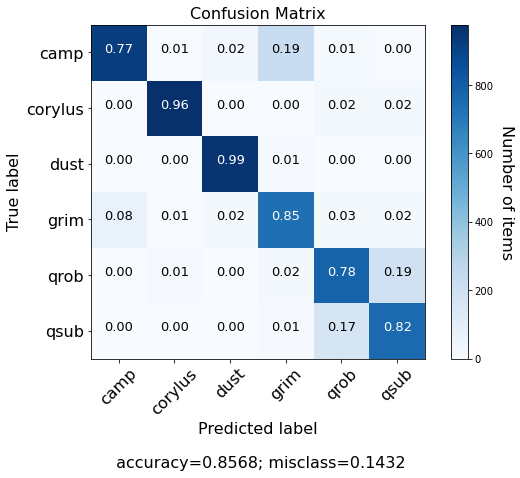

In [11]:
random_forest = RandomForestClassifier(n_estimators=1000, max_features='sqrt', 
                                       max_depth=50, random_state=None, n_jobs=-1)
# run the model
random_forest.fit(X_train, Y_train)
# predict on the validation set
Y_pred = random_forest.predict(X_val)
# calculate the score on the val dataset by comparing the predictions with the grund truth
acc_random_forest = metrics.accuracy_score(Y_val, Y_pred, normalize=True)
print(f'Random forest accuracy {acc_random_forest:.2f}')

# The last two commands are equivalent to just doing this:
# acc_random_forest = random_forest.score(X_val, Y_val)
# print(acc_random_forest)


# The higher, the more important the feature. 
# The importance of a feature is computed as the (normalized) total reduction 
# of the criterion brought by that feature. It is also known as the Gini importance.
importances = random_forest.feature_importances_
forest_importances = pd.DataFrame({'importances': importances}, index=feature_names).sort_values(by='importances', ascending=False)
print(forest_importances)

cm = confusion_matrix(Y_pred, Y_val)
# print(cm)
plot_confusion_matrix(cm, 
                      normalize    = True,
                      target_names = ['camp', 'corylus', 'dust', 'grim', 'qrob', 'qsub'],
                      title        = "Confusion Matrix")

### Decision Tree

In [12]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)

Y_pred = decision_tree.predict(X_val)

acc_decision_tree = metrics.accuracy_score(Y_val, Y_pred, normalize=True)
print(f'Decision tree accuracy {acc_decision_tree:.2f}')

Decision tree accuracy 0.80


### Adaboost classifier

In [13]:
bdt_real = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=600,
    learning_rate=1)

bdt_discrete = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=50),
    n_estimators=1000,
    learning_rate=1.5,
    algorithm="SAMME")

bdt_real.fit(X_train, Y_train)
bdt_discrete.fit(X_train, Y_train)

Y_pred_read = bdt_real.predict(X_val)
Y_pred_discrete = bdt_discrete.predict(X_val)

acc_bdt_real = metrics.accuracy_score(Y_val, Y_pred_read, normalize=True)
acc_bdt_discrete = metrics.accuracy_score(Y_val, Y_pred_discrete, normalize=True)
print(f'bdt accuracy {acc_bdt_real:.2f} {acc_bdt_discrete:.2f}')

bdt accuracy 0.50 0.80


### Gaussian Naive Bayes

In [14]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_val)

acc_gaussian = metrics.accuracy_score(Y_val, Y_pred, normalize=True)

print(f'Gaussian Naive Bayes {acc_gaussian:.2f}')

Gaussian Naive Bayes 0.63


### Perceptron

In [15]:
# Perceptron

perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_val)

acc_perceptron = metrics.accuracy_score(Y_val, Y_pred, normalize=True)

print(f'Perceptron {acc_perceptron:.2f}')

Perceptron 0.24


### Linear SVC

In [16]:
# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_val)

acc_linear_svc = metrics.accuracy_score(Y_val, Y_pred, normalize=True)

print(f'Linear SVC {acc_linear_svc:.2f}')


Linear SVC 0.53


/home/nico/anaconda3/envs/Icelearning/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


### Support Vector Machines

In [17]:
# Support Vector Machines

svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_val)

acc_svm = metrics.accuracy_score(Y_val, Y_pred, normalize=True)

print(f'SVM {acc_svm:.2f}')

SVM 0.72


### KNN

In [18]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_val)

acc_knn = metrics.accuracy_score(Y_val, Y_pred, normalize=True)

print(f'KNN {acc_knn:.2f}')

KNN 0.76


### SGD

In [19]:
# Stochastic Gradient Descent

sgd = SGDClassifier(loss='hinge', penalty='l2')
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_val)

acc_sgd = metrics.accuracy_score(Y_val, Y_pred, normalize=True)

print(f'SGD {acc_sgd:.2f}')

SGD 0.56


### Logistic regression

In [20]:
# Logistic Regression

logreg = LogisticRegression(max_iter=5000)
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_val)

acc_log = metrics.accuracy_score(Y_val, Y_pred, normalize=True)

print(f'Logistic regression {acc_log:.2f}')

Logistic regression 0.77


/home/nico/anaconda3/envs/Icelearning/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Model evaluation

In [21]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svm, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})

models.sort_values(by='Score', ascending=False)


,Model,Score
3,Random Forest,0.856833
8,Decision Tree,0.797333
2,Logistic Regression,0.769500
1,KNN,0.756833
0,Support Vector Machines,0.716333
4,Naive Bayes,0.634000
6,Stochastic Gradient Decent,0.561833
7,Linear SVC,0.532667
5,Perceptron,0.243833
